# Code used to analyze heatwaves in preparation for the main figure paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
from extremeweatherbench import evaluate, utils, cases, defaults, inputs, metrics, regions
sns.set_theme(style='whitegrid')
import shapely
from pathlib import Path
import multiprocessing
import xarray as xr
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from collections import namedtuple

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

import src.plots.plotting_utils as plot_utils  # noqa: E402
import src.plots.results_utils as results_utils  # noqa: E402
import src.plots.results_utils as results_utils  # noqa: E402
import src.plots.heat_freeze_utils as heat_freeze_utils  # noqa: E402

import operator

# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()
# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources
# to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


In [3]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

accessible_colors = [
    "#3394D6",  # blue
    "#E09000",  #  orange "#E69F00",  # orange
    "#A15A7E",  # "#CC79A7",  # reddish purple
    "#CC4A4A",  #  vermillion"#D55E00",  # vermillion
    "#A0A0A0",  # Grey "#000000",  # black
    "#B2B24D",  # Olive
    "#33B890",  # bluish green
    "#78C6F1",  # sky blue
    "#F0E442",  # yellow
]

# defaults for plotting
fourv2_style = {'color': accessible_colors[0]}
gc_style = {'color': accessible_colors[2]}
pangu_style = {'color': accessible_colors[3]}
hres_style = {'color': 'black'}

# the group styles and settings so that we can just easily grab them for the plots and they are globally consistent

ghcn_group_style = {'linestyle':'-', 'marker':'o', 'group':'GHCN'}
era5_group_style = {'linestyle':'--', 'marker':'s', 'group':'ERA5'}

ifs_group_style = {'linestyle':'-', 'marker':'o', 'group':'IFS'}
gfs_group_style = {'linestyle':':', 'marker':'d', 'group':'GFS'}

global_group_style = {'linestyle':'--', 'marker':'*', 'group':'Global'}

hres_group_style = {'linestyle':'-', 'marker':'.', 'group':'HRES'}

# settings for the different models
fourv2_ifs_cira_settings = {'forecast_source':'CIRA FOURv2 IFS', 'label_str': 'ForecastNet V2'} 
fourv2_gfs_cira_settings = {'forecast_source':'CIRA FOURv2 GFS', 'label_str': 'ForecastNet V2'} 
gc_ifs_cira_settings = {'forecast_source':'CIRA GC IFS', 'label_str': 'GraphCast'} 
gc_gfs_cira_settings = {'forecast_source':'CIRA GC GFS', 'label_str': 'GraphCast'} 
pangu_ifs_cira_settings = {'forecast_source':'CIRA PANG IFS', 'label_str': 'Pangu Weather'} 
pangu_gfs_cira_settings = {'forecast_source':'CIRA PANG GFS', 'label_str': 'Pangu Weather'} 

hres_ifs_settings = {'forecast_source':'ECMWF HRES', 'label_str': 'HRES'} 

fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | ifs_group_style
gc_ifs_settings = gc_ifs_cira_settings | gc_style | ifs_group_style
pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | ifs_group_style
hres_settings = hres_ifs_settings | hres_style | hres_group_style


In [4]:
# load the results back in
fourv2_heat_results = pd.read_pickle(basepath + 'saved_data/fourv2_heat_results.pkl')
pang_heat_results = pd.read_pickle(basepath + 'saved_data/pang_heat_results.pkl')
hres_heat_results = pd.read_pickle(basepath + 'saved_data/hres_heat_results.pkl')
gc_heat_results = pd.read_pickle(basepath + 'saved_data/gc_heat_results.pkl')


fourv2_freeze_results = pd.read_pickle(basepath + 'saved_data/fourv2_freeze_results.pkl')
pang_freeze_results = pd.read_pickle(basepath + 'saved_data/pang_freeze_results.pkl')
hres_freeze_results = pd.read_pickle(basepath + 'saved_data/hres_freeze_results.pkl')
gc_freeze_results = pd.read_pickle(basepath + 'saved_data/gc_freeze_results.pkl')

# example plots 

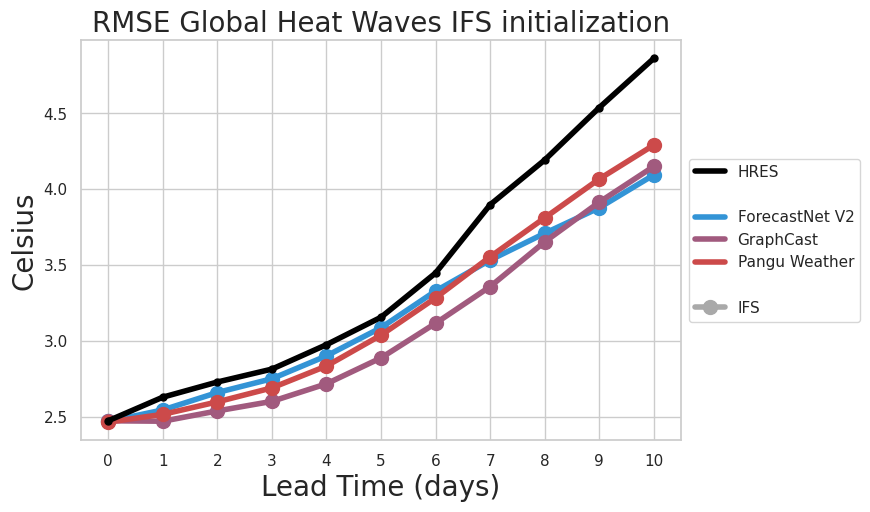

In [5]:
# plot the results for one metric for the three AI models versus HRES
fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | ifs_group_style
gc_ifs_settings = gc_ifs_cira_settings | gc_style | ifs_group_style
pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | ifs_group_style
hres_settings = hres_ifs_settings | hres_style | hres_group_style

# subset the data for the plot
fourv2_ifs_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
gc_ifs_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
pangu_ifs_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_settings['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
hres_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')

# plot the results
data = [fourv2_ifs_plot, gc_ifs_plot, pangu_ifs_plot, hres_plot]
settings = [fourv2_ifs_settings, gc_ifs_settings, pangu_ifs_settings, hres_settings]
plot_utils.plot_results_by_metric(data=data, settings=settings, title='RMSE Global Heat Waves IFS initialization')


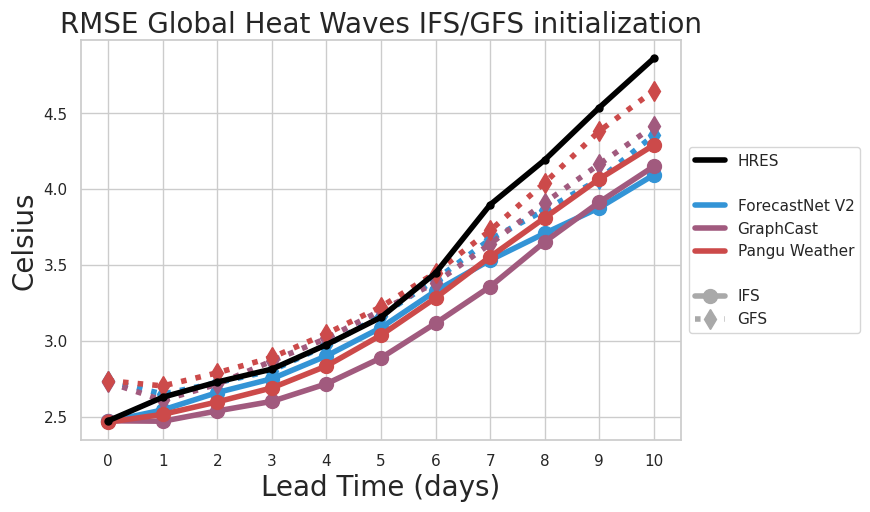

In [6]:
# compare IFS/GFS
# setup the settings for the plots      
fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | gfs_group_style
gc_gfs_settings = gc_gfs_cira_settings | gc_style | gfs_group_style
pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | gfs_group_style

# subset the data for the plots
fourv2_gfs_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
        forecast_source=fourv2_gfs_settings['forecast_source'], 
        target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
gc_gfs_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
        forecast_source=gc_gfs_settings['forecast_source'], 
        target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
pangu_gfs_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
        forecast_source=pangu_gfs_settings['forecast_source'], 
        target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')

# plot the results
data = [fourv2_ifs_plot, fourv2_gfs_plot, gc_ifs_plot, gc_gfs_plot, pangu_ifs_plot, pangu_gfs_plot, hres_plot]
settings = [fourv2_ifs_settings, fourv2_gfs_settings, gc_ifs_settings, gc_gfs_settings, pangu_ifs_settings, pangu_gfs_settings, hres_settings]
plot_utils.plot_results_by_metric(data=data, settings=settings, title='RMSE Global Heat Waves IFS/GFS initialization', show_all_in_legend=False)


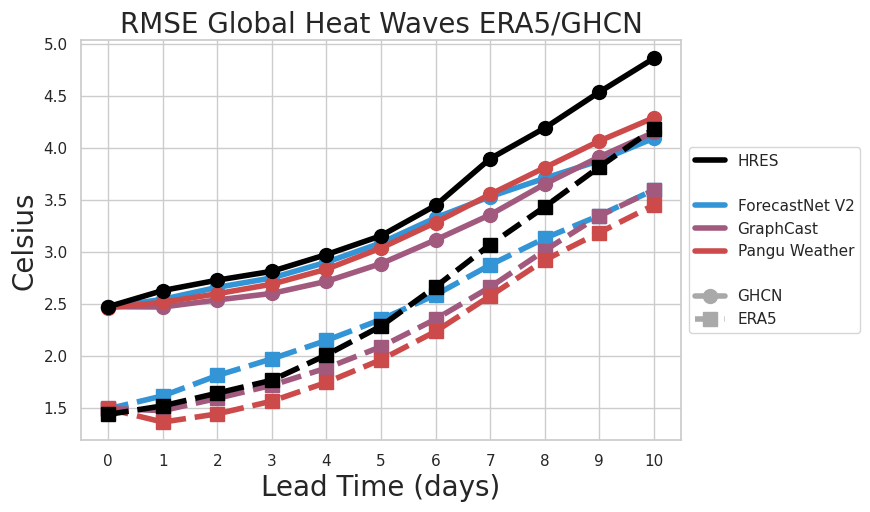

In [7]:
# plot ERA5 versus GHCN for IFS
fourv2_ifs_ghcn_settings = fourv2_ifs_cira_settings | fourv2_style | ghcn_group_style
gc_ifs_ghcn_settings = gc_ifs_cira_settings | gc_style | ghcn_group_style
pangu_ifs_ghcn_settings = pangu_ifs_cira_settings | pangu_style | ghcn_group_style
hres_ghcn_settings = hres_ifs_settings | hres_style | ghcn_group_style

fourv2_ifs_era5_settings = fourv2_ifs_cira_settings | fourv2_style | era5_group_style
gc_ifs_era5_settings = gc_ifs_cira_settings | gc_style | era5_group_style
pangu_ifs_era5_settings = pangu_ifs_cira_settings | pangu_style | era5_group_style
hres_era5_settings = hres_ifs_settings | hres_style | era5_group_style

# subset the data for the plots
fourv2_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_ghcn_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
gc_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_ghcn_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
pangu_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_ghcn_settings['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')
hres_ghcn_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_ghcn_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz')

fourv2_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_era5_settings['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', init_time='zeroz')
gc_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_era5_settings['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', init_time='zeroz')
pangu_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_era5_settings['forecast_source'],
    target_source='ERA5', metric='RootMeanSquaredError', init_time='zeroz')
hres_era5_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_era5_settings['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', init_time='zeroz')

# plot the results
data = [fourv2_ifs_ghcn_plot, fourv2_ifs_era5_plot, gc_ifs_ghcn_plot, gc_ifs_era5_plot, 
    pangu_ifs_ghcn_plot, pangu_ifs_era5_plot, hres_ghcn_plot, hres_era5_plot]
settings = [fourv2_ifs_ghcn_settings, fourv2_ifs_era5_settings, gc_ifs_ghcn_settings, 
    gc_ifs_era5_settings, pangu_ifs_ghcn_settings, pangu_ifs_era5_settings, hres_ghcn_settings, hres_era5_settings]

plot_utils.plot_results_by_metric(data=data, settings= settings, title='RMSE Global Heat Waves ERA5/GHCN', show_all_in_legend=False)


# analysis at the regional level

North America Cases: [1, 2, 3, 4, 5, 6, 27, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 84, 87, 88, 89, 95, 96, 97, 101, 102, 103, 104, 105, 106, 109, 110, 111, 112, 113, 114, 115, 118, 119, 121, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 194, 195, 196, 197, 198, 199, 200, 201, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337]
Europe Cases

/home/amy/extreme-weather-bench-paper/src/plots/plotting_utils.py:1187: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower left", fontsize=12)


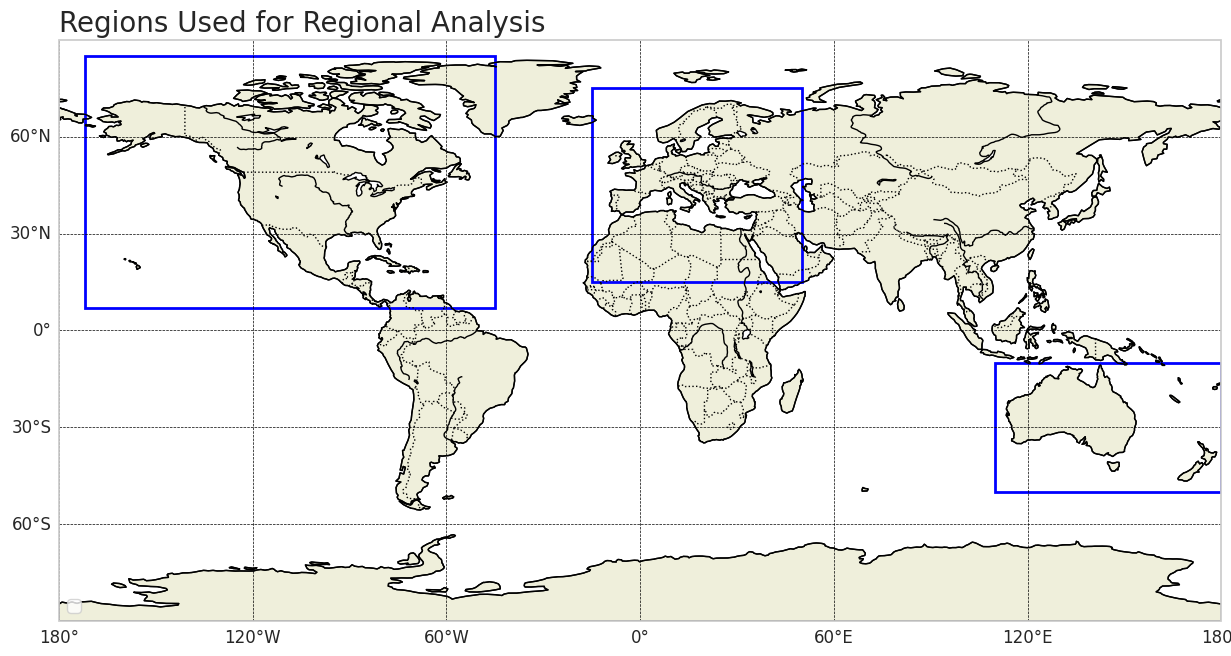

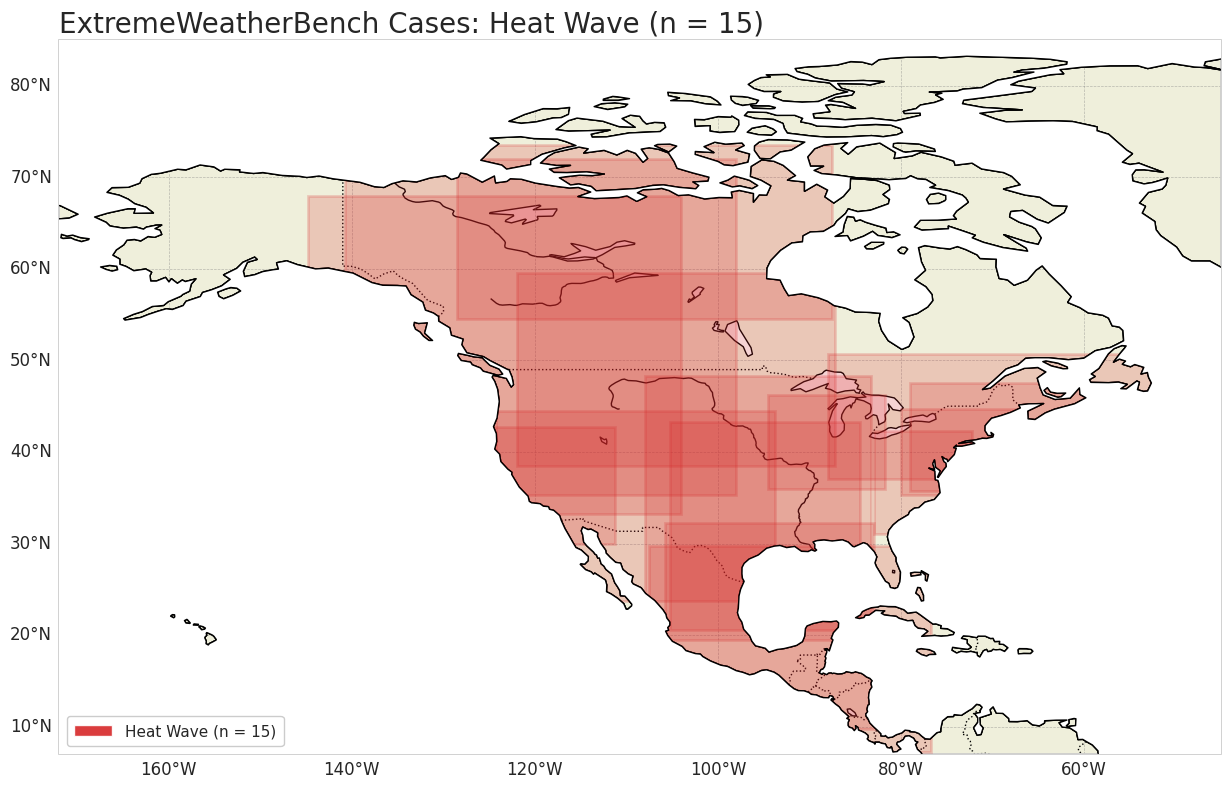

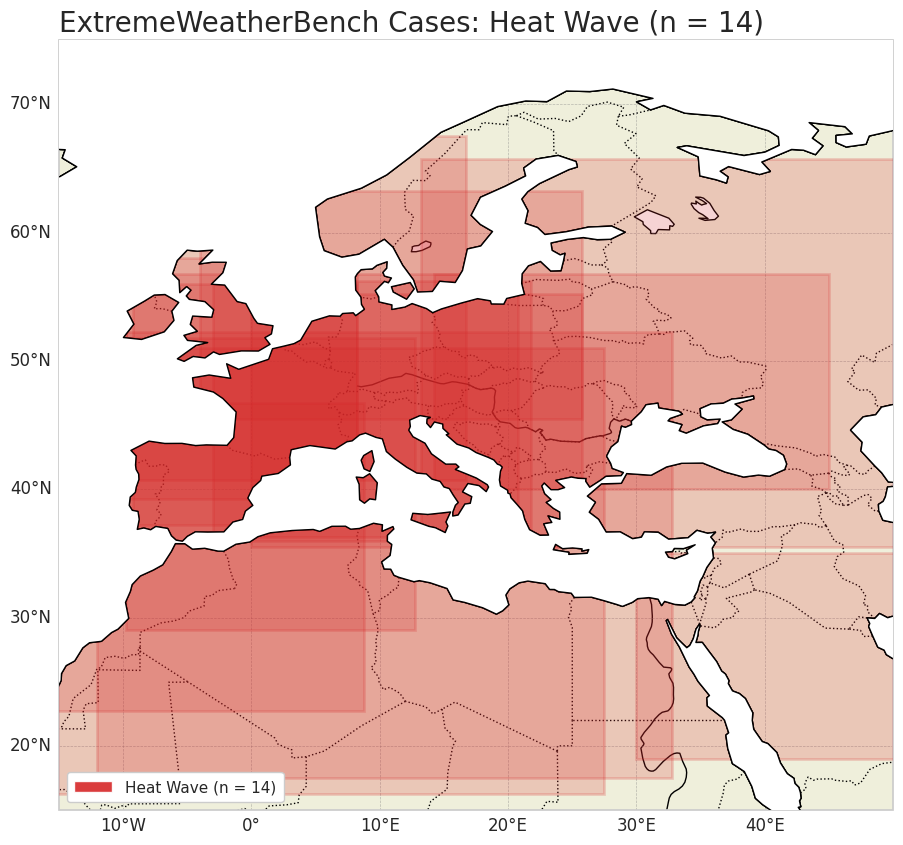

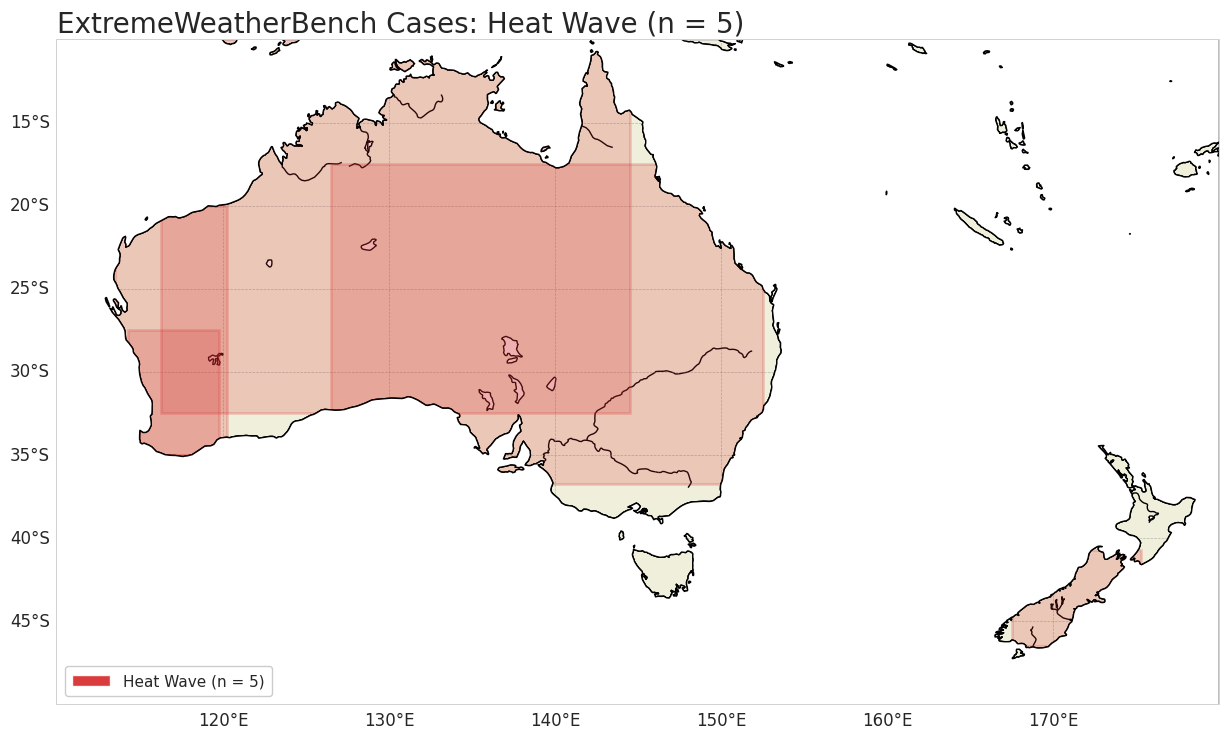

In [8]:
# make the bounding boxes for the regions

# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(na_bounding_box)
na_bounding_region = regions.BoundingBoxRegion(latitude_min=7, latitude_max=85, longitude_min=-172, longitude_max=-45)

# Europe bounding box
eu_bounding_box = [50, -15, 15, 75]
eu_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(eu_bounding_box)
eu_bounding_region = regions.BoundingBoxRegion(latitude_min=50, latitude_max=75, longitude_min=-15, longitude_max=15)

# australia bounding box
au_bounding_box = [110, 180, -50, -10]
au_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(au_bounding_box)
au_bounding_region = regions.BoundingBoxRegion(latitude_min=-50, latitude_max=-10, longitude_min=110, longitude_max=180)

# break the cases into different lists
na_subset = regions.RegionSubsetter(region=na_bounding_region, method='intersects').subset_case_collection(ewb_cases)
eu_subset = regions.RegionSubsetter(region=eu_bounding_region, method='intersects').subset_case_collection(ewb_cases)
au_subset = regions.RegionSubsetter(region=au_bounding_region, method='intersects').subset_case_collection(ewb_cases)

na_case_ids = [n.case_id_number for n in na_subset.cases]
eu_case_ids = [n.case_id_number for n in eu_subset.cases]
au_case_ids = [n.case_id_number for n in au_subset.cases]

print(f'North America Cases: {na_case_ids}')
print(f'Europe Cases: {eu_case_ids}')
print(f'Australia Cases: {au_case_ids}')

# plot the regions
plot_utils.plot_boxes(
    box_list=[na_bounding_box_polygon, eu_bounding_box_polygon, au_bounding_box_polygon],
    box_names=['North America', 'Europe', 'Australia'],
    title='Regions Used for Regional Analysis',
)

# plot North America cases
plot_utils.plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=na_bounding_box, 
    fill_boxes=True)

plot_utils.plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=eu_bounding_box, 
    fill_boxes=True)

plot_utils.plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=au_bounding_box, 
    fill_boxes=True)

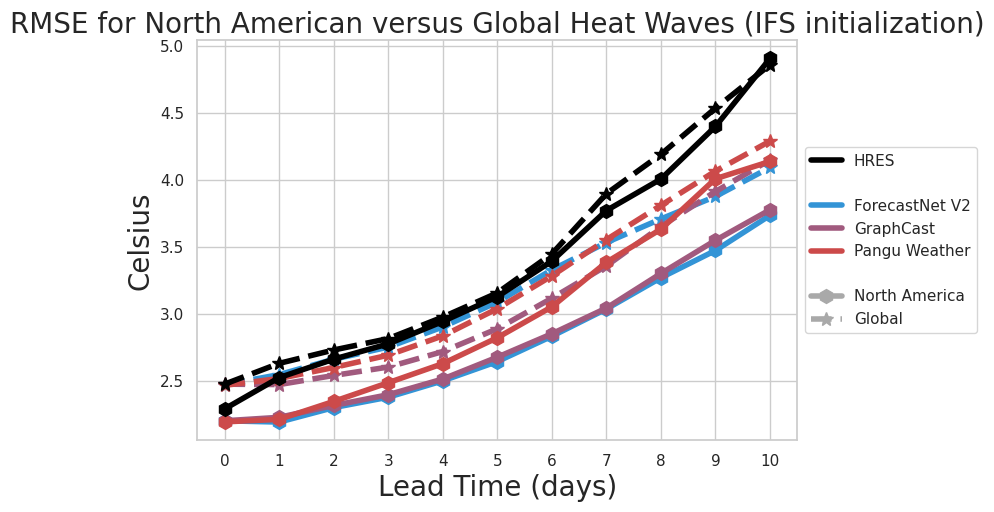

In [9]:
# create a group style for the local/global plots
na_group_style = {'linestyle':'-', 'marker':'h', 'group':'North America'}
eu_group_style = {'linestyle':'-', 'marker':'h', 'group':'Europe'}
au_group_style = {'linestyle':'-', 'marker':'h', 'group':'Australia'}

# plot the results for one metric for the three AI models versus HRES
na_fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | na_group_style
na_gc_ifs_settings = gc_ifs_cira_settings | gc_style | na_group_style
na_pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | na_group_style
na_hres_settings = hres_ifs_settings | hres_style | na_group_style

# subset the data for the plots
na_fourv2_ifs_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=na_case_ids)
na_gc_ifs_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=na_case_ids)
na_pangu_ifs_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_settings['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=na_case_ids)
na_hres_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=na_case_ids)

# make a global settings so we can compare
fourv2_ifs_global_settings = fourv2_ifs_cira_settings | fourv2_style | global_group_style
pangu_ifs_global_settings = pangu_ifs_cira_settings | pangu_style | global_group_style
gc_ifs_global_settings = gc_ifs_cira_settings | gc_style | global_group_style
hres_settings_global = hres_ifs_settings | hres_style | global_group_style

# plot the results
data = [na_fourv2_ifs_plot, fourv2_ifs_plot, na_gc_ifs_plot, gc_ifs_plot, na_pangu_ifs_plot, pangu_ifs_plot, na_hres_plot, hres_plot]
settings = [na_fourv2_ifs_settings, fourv2_ifs_global_settings, na_gc_ifs_settings, gc_ifs_global_settings, 
    na_pangu_ifs_settings, pangu_ifs_global_settings, na_hres_settings, hres_settings_global]
plot_utils.plot_results_by_metric(data=data, settings=settings, title='RMSE for North American versus Global Heat Waves (IFS initialization)')


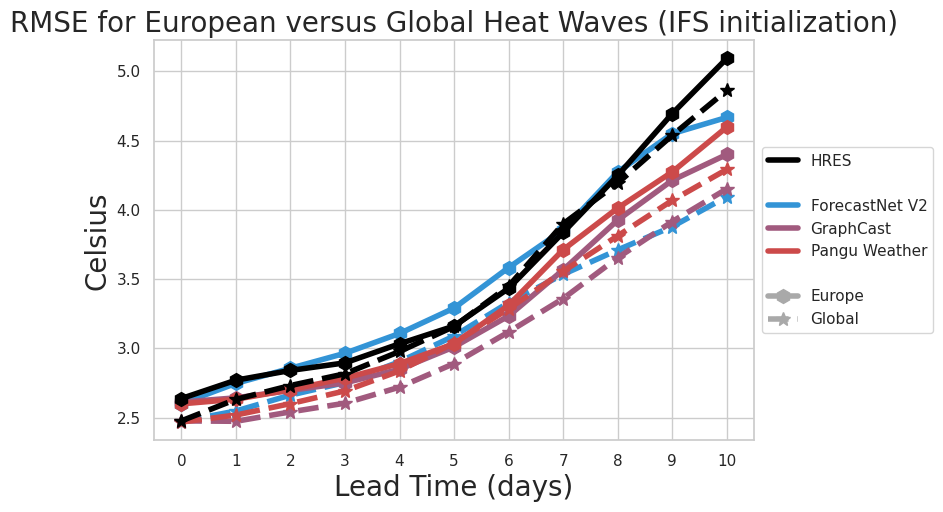

In [10]:
# plot the results for the european cases
eu_fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | eu_group_style
eu_gc_ifs_settings = gc_ifs_cira_settings | gc_style | eu_group_style
eu_pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | eu_group_style
eu_hres_settings = hres_ifs_settings | hres_style | eu_group_style

# subset the data for the plots
eu_fourv2_ifs_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=eu_case_ids)
eu_gc_ifs_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=eu_case_ids)
eu_pangu_ifs_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_settings['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=eu_case_ids)
eu_hres_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=eu_case_ids)

# plot the results
data = [eu_fourv2_ifs_plot, fourv2_ifs_plot, eu_gc_ifs_plot, gc_ifs_plot, eu_pangu_ifs_plot, pangu_ifs_plot, eu_hres_plot, hres_plot]
settings = [eu_fourv2_ifs_settings, fourv2_ifs_global_settings, eu_gc_ifs_settings, gc_ifs_global_settings, 
    eu_pangu_ifs_settings, pangu_ifs_global_settings, eu_hres_settings, hres_settings_global]
plot_utils.plot_results_by_metric(data=data, settings=settings, title='RMSE for European versus Global Heat Waves (IFS initialization)')

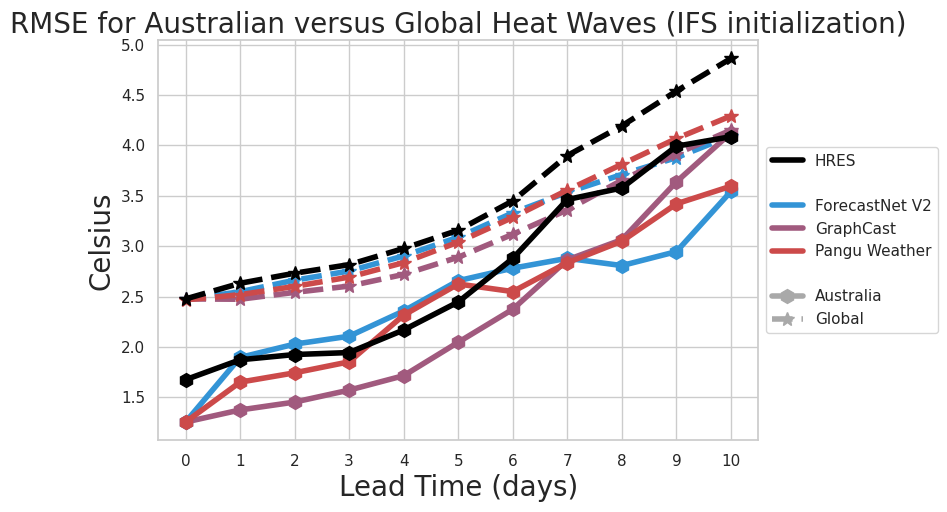

In [11]:
# plot the results for the australian cases
au_fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | au_group_style
au_gc_ifs_settings = gc_ifs_cira_settings | gc_style | au_group_style
au_pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | au_group_style
au_hres_settings = hres_ifs_settings | hres_style | au_group_style

# subset the data for the plots
au_fourv2_ifs_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=au_case_ids)
au_gc_ifs_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=au_case_ids)
au_pangu_ifs_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_settings['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=au_case_ids)
au_hres_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=au_case_ids)

# plot the results
data = [au_fourv2_ifs_plot, fourv2_ifs_plot, au_gc_ifs_plot, gc_ifs_plot, au_pangu_ifs_plot, pangu_ifs_plot, au_hres_plot, hres_plot]
settings = [au_fourv2_ifs_settings, fourv2_ifs_global_settings, au_gc_ifs_settings, gc_ifs_global_settings, 
    au_pangu_ifs_settings, pangu_ifs_global_settings, au_hres_settings, hres_settings_global]
plot_utils.plot_results_by_metric(data=data, settings=settings, title='RMSE for Australian versus Global Heat Waves (IFS initialization)')



# dive into one example in depth

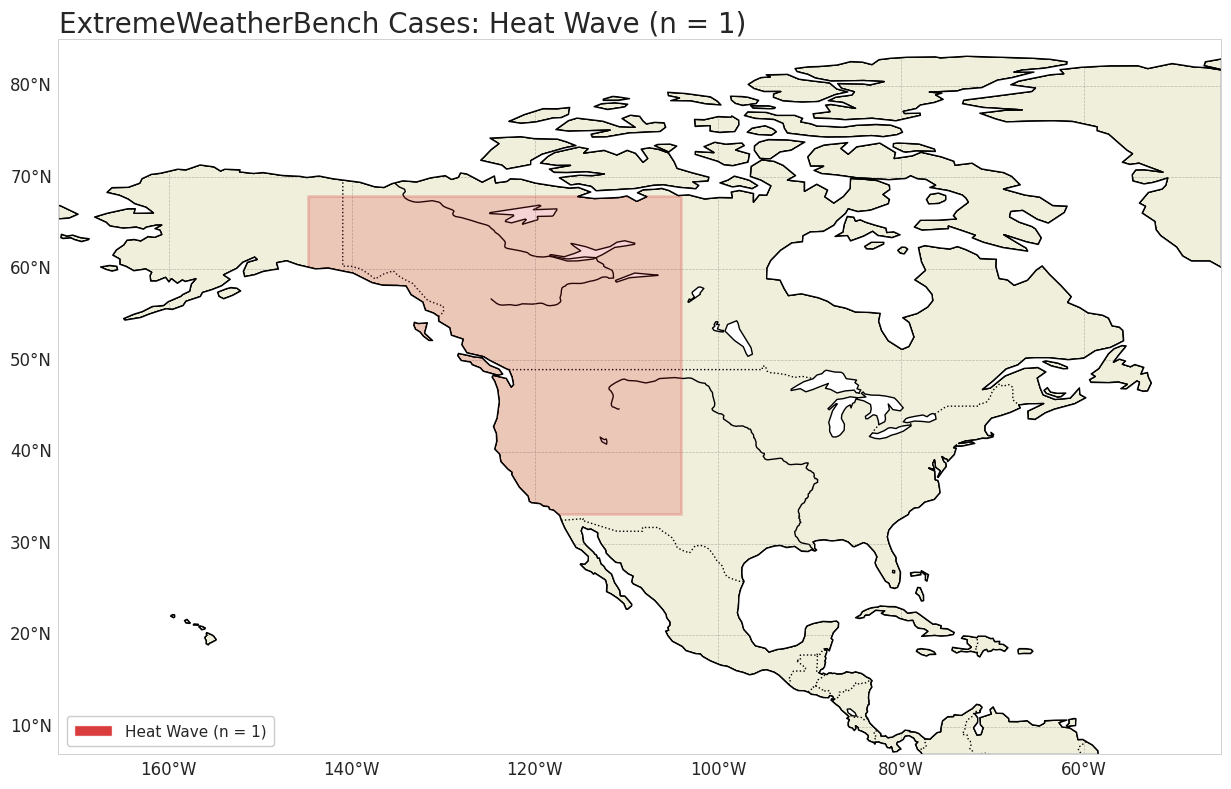

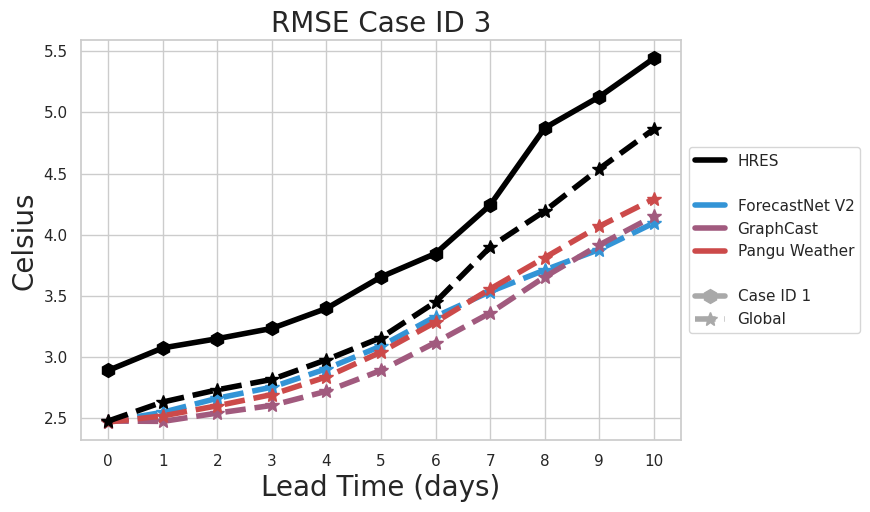

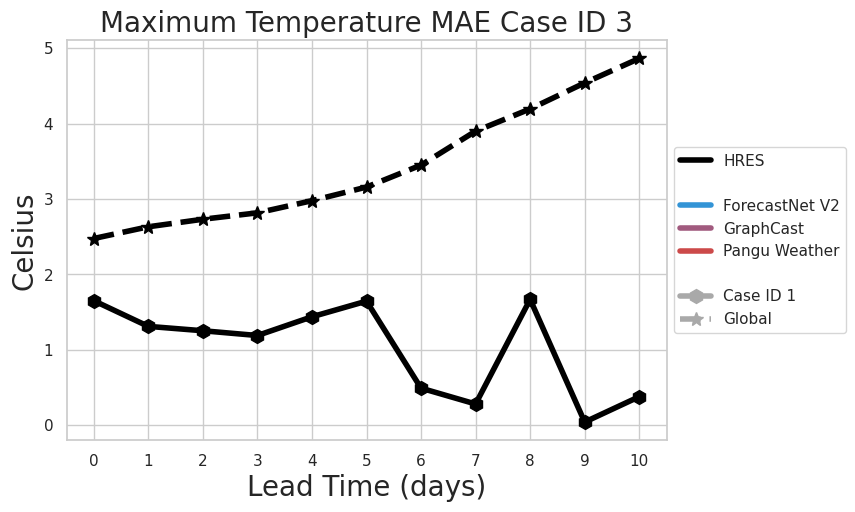

In [12]:
# for this example, we dive into case id 3
my_case = ewb_cases.select_cases('case_id_number',1)
my_case_id = my_case.cases[0].case_id_number

plot_utils.plot_all_cases(my_case, event_type='heat_wave', bounding_box=na_bounding_box, fill_boxes=True)

# make a style for the case id 3
my_group_style = {'linestyle':'-', 'marker':'h', 'group':'Case ID 1'}

# make the settings for the plots
my_fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | my_group_style
my_gc_ifs_settings = gc_ifs_cira_settings | gc_style | my_group_style
my_pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | my_group_style
my_hres_settings = hres_ifs_settings | hres_style | my_group_style

# subset the data for the plots
my_fourv2_ifs_plot = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=[my_case_id])
my_gc_ifs_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=[my_case_id])
my_pangu_ifs_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_settings['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=[my_case_id])
my_hres_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_settings['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', init_time='zeroz', case_id_list=[my_case_id])

# plot the results
data = [my_fourv2_ifs_plot, fourv2_ifs_plot, my_gc_ifs_plot, gc_ifs_plot, my_pangu_ifs_plot, pangu_ifs_plot, my_hres_plot, hres_plot]    
settings = [my_fourv2_ifs_settings, fourv2_ifs_settings | global_group_style, my_gc_ifs_settings, 
    gc_ifs_settings | global_group_style, my_pangu_ifs_settings, pangu_ifs_settings | global_group_style, my_hres_settings, 
    hres_settings | global_group_style]
plot_utils.plot_results_by_metric(data=data, settings=settings, title='RMSE Case ID 3')

# and make one more plot for the maximum temperature mae (same settings, just different data to plot)
my_fourv2_ifs_plot2 = results_utils.subset_results_to_xarray(results_df=fourv2_heat_results, 
    forecast_source=fourv2_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='MaximumMeanAbsoluteError', init_time='zeroz', case_id_list=[my_case_id])
my_gc_ifs_plot2 = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_ifs_settings['forecast_source'], 
    target_source='GHCN', metric='MaximumMeanAbsoluteError', init_time='zeroz', case_id_list=[my_case_id])
my_pangu_ifs_plot2 = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_ifs_settings['forecast_source'],
    target_source='GHCN', metric='MaximumMeanAbsoluteError', init_time='zeroz', case_id_list=[my_case_id])
my_hres_plot2 = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_settings['forecast_source'], 
    target_source='GHCN', metric='MaximumMeanAbsoluteError', init_time='zeroz', case_id_list=[my_case_id])

data = [my_fourv2_ifs_plot2, my_gc_ifs_plot2, my_pangu_ifs_plot2, my_hres_plot2, hres_plot]    
settings = [my_fourv2_ifs_settings, my_gc_ifs_settings, my_pangu_ifs_settings, my_hres_settings, hres_settings_global]
plot_utils.plot_results_by_metric(data=data, settings=settings, title='Maximum Temperature MAE Case ID 3')


/home/amy/extreme-weather-bench-paper/.venv/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1585: UserWarning: The following kwargs were not used by contour: 'ls'
  result = super().contour(*args, **kwargs)


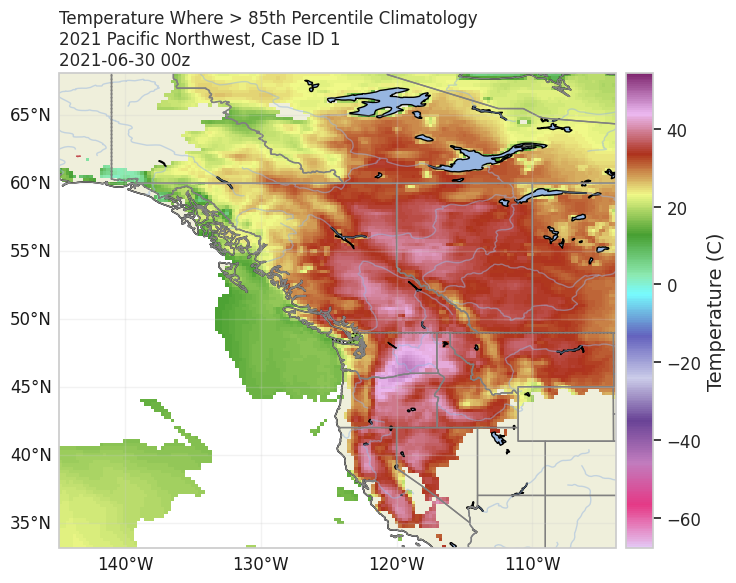

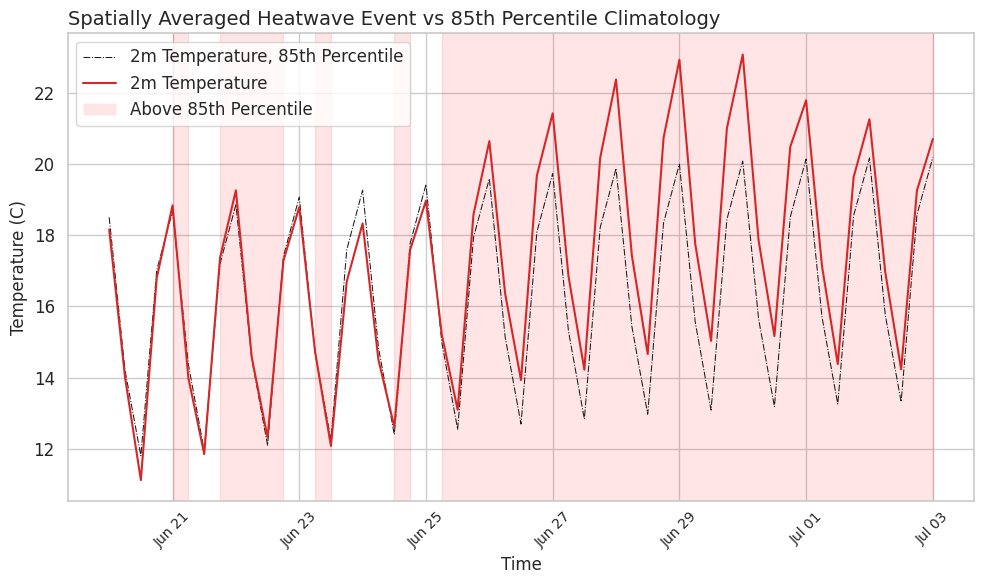

In [14]:
# show the individual data for this case
era5 = defaults.era5_heatwave_target.open_and_maybe_preprocess_data_from_source()
temp_climatology_ds = xr.open_zarr('gs://extremeweatherbench/datasets/surface_air_temperature_1990_2019_climatology.zarr/')
temp_climatology_ds = temp_climatology_ds.sel(quantile=0.85)
# load in all of the events in the yaml file
heatwave_dataset = heat_freeze_utils.generate_heatwave_dataset(era5, temp_climatology_ds, my_case.cases[0])
heat_freeze_utils.generate_heatwave_plots(heatwave_dataset, my_case.cases[0])

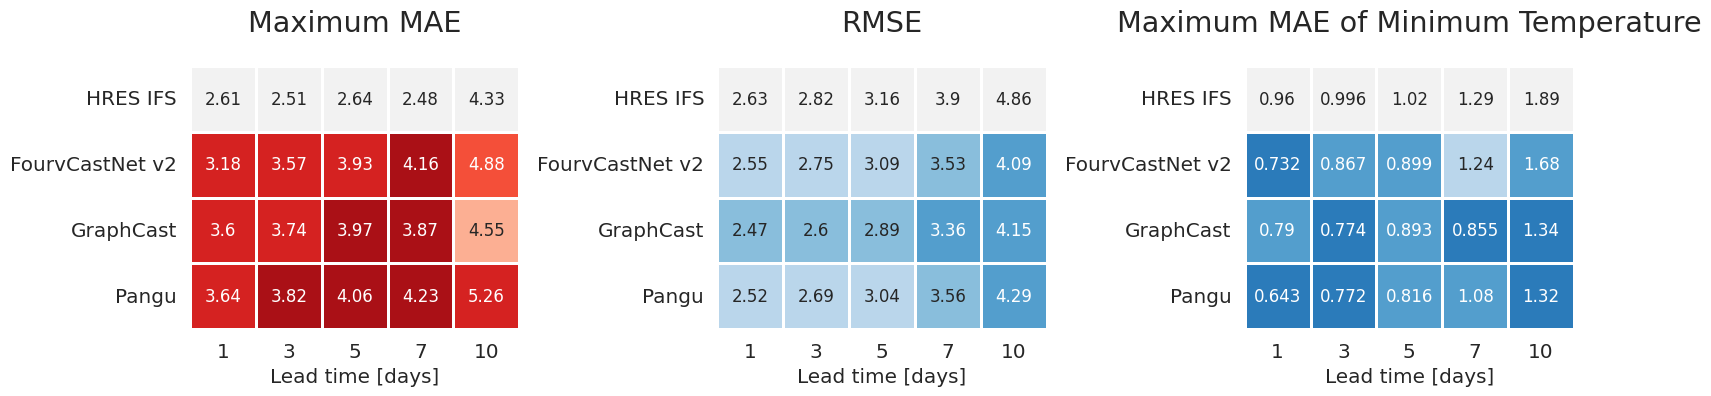

In [ ]:
# EWB scorecard for this case

def get_error_array_for_heatmap(results_array, hres_results, forecast_sources, 
    target_source, metric_strs, init_time, lead_time_days, higher_is_better_list):
    """
    This function takes in an array of results and parameters to say which results to grab and returns 
    error arrays and relative arrays for global, north america, and europe.
    """
    # now make the array for the scorecard
    rel_error = {}
    error = {}

    for i, metric in enumerate(metric_strs):
        # initialize the arrays
        rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        higher_is_better = higher_is_better_list[i]

        for j, results_df in enumerate(results_array):
            my_mean, my_relative_error = results_utils.compute_relative_error(results_df, 
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                higher_is_better=higher_is_better)
            error[metric][j, :] = my_mean
            rel_error[metric][j, :] = my_relative_error

    return error, rel_error

# setup for the scorecard
# Grab means for each metric for each model
heat_metric_str = ['MaximumMeanAbsoluteError', 'RootMeanSquaredError', 'MaximumLowestMeanAbsoluteError']
heat_display_str = ['Maximum MAE', 'RMSE', 'Maximum MAE of Minimum Temperature']
heat_metric_higher_is_better = [False, False, False]

lead_time_days = [1, 3, 5, 7, 10]

heat_results_array = [hres_heat_results, fourv2_heat_results, gc_heat_results, pang_heat_results]
forecast_source = [hres_ifs_settings['forecast_source'], 
    fourv2_ifs_settings['forecast_source'], 
    gc_ifs_settings['forecast_source'], pangu_ifs_settings['forecast_source']]

(heat_error, heat_rel_error) = \
    get_error_array_for_heatmap(heat_results_array, hres_heat_results, 
    forecast_source, 'GHCN', heat_metric_str, 'zeroz', lead_time_days, heat_metric_higher_is_better )

heat_settings = {}
heat_settings["subplot_titles"] = heat_display_str
heat_settings["metric_str"] = heat_metric_str
heat_settings["lead_time_days"] = lead_time_days
heat_settings["model_order"] = ["HRES IFS", "FourvCastNet v2", "GraphCast", "Pangu"]

plot_utils.plot_heatmap(
    heat_rel_error,
    heat_error,
    heat_settings,
)
